Douglas Leung

CFPB Data Science Project

General Assembly DAT8 Class

Last Updated: October 27, 2015



# Project Motivation

The datasets used in this project we're originally provided as part of a skills assessment test to the Consumer Finance Protection Bureau.  The test was to test for:

* Subject matter expertise
* Analitical thinking
* Written communication
    
When I started this project:

* I didn't have much subject matter expertise
* I like to think I'm a analitical thinker
* And this project will be at least help improve written communication


# What does the CFPB Do?
### According to the About Me Page as of (10/24/15):

>**About Us**
>
>The Consumer Financial Protection Bureau (CFPB) is a 21st century agency that helps consumer finance markets work by making >rules more effective, by consistently and fairly enforcing those rules, and by empowering consumers to take more control over >their economic lives.
> 
>[![About Us](http://img.youtube.com/vi/6-r4JFDsVmA/0.jpg)](https://www.youtube.com/watch?v=6-r4JFDsVmA)
>
>We work to:
>* **Educate**
>An informed consumer is the first line of defense against abusive practices.
>* **Enforce**
>We supervise banks, credit unions, and other financial companies, and we enforce federal consumer financial laws.
>* **Study**
>We gather and analyze available information to better understand consumers, financial services providers, and consumer financial markets.
>
>**Core Functions**
>
>We work to give consumers the information they need to understand the terms of their agreements with financial companies. We >are working to make regulations and guidance as clear and streamlined as possible so providers of consumer financial products >and services can follow the rules on their own.
>
>Congress established the CFPB to protect consumers by carrying out federal consumer financial laws. Among other things, we:
>
>* Write rules, supervise companies, and enforce federal consumer financial protection laws
>* Restrict unfair, deceptive, or abusive acts or practices
>* Take consumer complaints
>* Promote financial education
>* Research consumer behavior
>* Monitor financial markets for new risks to consumers
>* Enforce laws that outlaw discrimination and other unfair treatment in consumer finance
>
>(http://www.consumerfinance.gov/the-bureau/)


# The Project Question

### Can I predict if a comsumer will dispute a response based on their zipcode's percentages of income brackets? 

*With the premise that this project started out as a skills assessment test from the CFPB, this question was developed based on  given data sets.  In this case, I approached the data by applying categorization to consumer complaints data, while making use of the relevant income data sources from the American Community Survey.*

# My Hypothesis

I believe that there will be more disputes associated with zipcodes that have higher percentages of high income brackets.  This is because they have a greater amount of assets at risk, but also because they have more resources at their disposal.

In [449]:
#Import Libraries

#Data
import pandas as pd
import numpy as np

#Visual
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.tree import export_graphviz

#Learning
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics

from sklearn.linear_model import LogisticRegression

# Import Consumer Complaints Data
<img src="CFPB_2tone_Horiz_RGB.png" width="500">
Source: (http://www.consumerfinance.gov/complaintdatabase/)

The Complaints data can be access by downloading a file in your desired format, or you can utilize their API's.  I have chosen to download the CSV file to get all the fields available in one file.

Further documentation on the fields and hwo to utilize their API can be found in the following link (http://www.consumerfinance.gov/complaintdatabase/technical-documentation/).


In [450]:
Complaints = pd.read_csv('Consumer_Complaints.csv', low_memory =False)
Complaints.columns = [c.replace(' ', '_') for c in Complaints.columns]
print Complaints.shape
Complaints.head()

(419985, 16)


,Date_received,Product,Sub-product,Issue,Sub-issue,Consumer_complaint_narrative,Company_public_response,Company,State,ZIP_code,Submitted_via,Date_sent_to_company,Company_response_to_consumer,Timely_response?,Consumer_disputed?,Complaint_ID
0,07/15/2015,Bank account or service,Checking account,Problems caused by my funds being low,NaN,NaN,NaN,Santander Bank US,NJ,088XX,Web,07/15/2015,In progress,Yes,NaN,1470116
1,07/15/2015,Debt collection,"Other (phone, health club, etc.)",Disclosure verification of debt,Not given enough info to verify debt,NaN,NaN,Transworld Systems Inc.,NY,11226,Web,07/15/2015,In progress,Yes,NaN,1469995
2,07/15/2015,Debt collection,Payday loan,False statements or representation,Impersonated an attorney or official,NaN,NaN,"Green Tree Servicing, LLC",PA,174XX,Web,07/15/2015,Closed with explanation,Yes,NaN,1469985
3,07/15/2015,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,Flagstar Bank,TN,381XX,Web,07/15/2015,In progress,Yes,NaN,1470653
4,07/15/2015,Debt collection,Mortgage,Communication tactics,Frequent or repeated calls,NaN,NaN,Ocwen,NC,274XX,Web,07/15/2015,Closed with explanation,Yes,NaN,1469337


In [451]:
Complaints.dtypes

Date_received                   object
Product                         object
Sub-product                     object
Issue                           object
Sub-issue                       object
Consumer_complaint_narrative    object
Company_public_response         object
Company                         object
State                           object
ZIP_code                        object
Submitted_via                   object
Date_sent_to_company            object
Company_response_to_consumer    object
Timely_response?                object
Consumer_disputed?              object
Complaint_ID                     int64
dtype: object

In [452]:
Complaints.isnull().sum()

Date_received                        0
Product                              0
Sub-product                     132678
Issue                                6
Sub-issue                       286503
Consumer_complaint_narrative    409046
Company_public_response         403899
Company                              0
State                             5740
ZIP_code                          5503
Submitted_via                        0
Date_sent_to_company                 0
Company_response_to_consumer         0
Timely_response?                     0
Consumer_disputed?               32141
Complaint_ID                         0
dtype: int64

## Clean Complaints Data
  
* In progress complaints will be removed because they shouldn't have a dispute status
* Columns will be minimized to only those that are necessary to make joining easier
* Remove NaN zipcodes as that will be how we join dataframes
* Remove any non 5-digit zipcodes, and convert to INT datatype
    * "XX" retired - Large land areas such as national parks do not have ZCTA coverage
    * "HH" suffix used to represent large water bodies	"HH" retired - Large water bodies do not have ZCTA coverage
* Establish how we will deal with null reponse variables

In [453]:
#Remove "In progress" Complaints because they shouldn't have a dispute status
Complaints = Complaints[Complaints.Company_response_to_consumer != 'In progress']

#Minimize to only the necessary columns
Complaints = Complaints[['Complaint_ID', 'ZIP_code', 'Consumer_disputed?']]

#Prepare Complaints for joining on ZIP_code
Complaints.dropna(subset = ['ZIP_code'], inplace = True)
Complaints = Complaints[Complaints.ZIP_code.str.contains("XX") == False]
Complaints[['ZIP_code']] = Complaints [['ZIP_code']].astype(int)
print Complaints.shape

#How will we deal with NaN's in the response variable?
print Complaints['Consumer_disputed?'].isnull().value_counts()

(391798, 3)
False    372396
True      19402
dtype: int64


## Two Options for NaN's in the 'Consumer_disputed?' column

1. Fill each Non-Response as 'No' under the assumption that anything is not a 'Yes' is simply not disputing.
 
2. Non-Response cannot be determined to be 'Yes' or 'No', so we will leave them NaN in a new field

In [454]:
#Create New Field for Approach 2
Complaints['Disputed_NaN'] = Complaints['Consumer_disputed?']

#Fill in NaN's with No for Approach 1
Complaints['Consumer_disputed?'].fillna('No', inplace=True)

#Convert to Binary Reponse
Complaints['Disputed_Bit'] = Complaints['Consumer_disputed?'].map({'Yes':1, 'No':0})
Complaints['Disputed_NaN'] = ComplaintsDrop['Consumer_disputed?'].map({'Yes':1, 'No':0})

print Complaints.shape
print Complaints.isnull().sum()

(391798, 5)
Complaint_ID              0
ZIP_code                  0
Consumer_disputed?        0
Disputed_NaN          19402
Disputed_Bit              0
dtype: int64



# Import Geography Data
<img src="zcta.gif" width="300">
### Geography information for the 5-year ACS survey file from census.gov

CSV data file: (http://www2.census.gov/acs2013_5yr/summaryfile/2009-2013_ACSSF_By_State_By_Sequence_Table_Subset/UnitedStates/All_Geographies_Not_Tracts_Block_Groups/g20135us.csv)

PDF for header fields: (http://www2.census.gov/acs2013_5yr/summaryfile/ACS_2013_SF_Tech_Doc.pdf)

Within the PDF, the field titles are provided on Page 10.  I have manually typed the titles to be attached onto the data import.  Few of the fields within the file are actually important and it is mainly used as a bridge between the Complaints Data and the Income Data that will be imported after this. 

In [455]:
#Import Geography Data
geo_cols = ['FILEID', 'STUSAB', 'SUMLEVEL', 'COMPONENT', 'LOGRECNO', 'US', 'REGION', 'DIVISION', 'STATECE', 'STATE', 'COUNTY', 'COUSUB', 'PLACE', 'TRACT', 'BLKGRP', 'CONCIT', 'AIANHH', 'AIANHHFP', 'AIHHTLI', 'AITSCE', 'AITS', 'ANRC', 'CBSA', 'CSA', 'METDIV', 'MACC', 'MEMI', 'NECTA', 'CNECTA', 'NECTADIV', 'UA', 'BLANK', 'CDCURR', 'SLDU', 'SLDL', 'BLANK', 'BLANK', 'ZCTA5', 'SUBMCD', 'SDELM', 'SDSEC', 'SDUNI', 'UR', 'PCI', 'BLANK', 'BLANK', 'PUMA5', 'BLANK', 'GEOID', 'NAME', 'BTTR', 'BTBG', 'BLANK']
Geography = pd.read_csv('g20135us.csv', low_memory = False, names=geo_cols, index_col='LOGRECNO')
Geography.head()

,FILEID,STUSAB,SUMLEVEL,COMPONENT,US,REGION,DIVISION,STATECE,STATE,COUNTY,...,PCI,BLANK,BLANK,PUMA5,BLANK,GEOID,NAME,BTTR,BTBG,BLANK
LOGRECNO,,,,,,,,,,,,,,,,,,,,,
1,ACSSF,US,10,00,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,01000US,United States,NaN,NaN,NaN
2,ACSSF,US,10,01,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,01001US,United States -- Urban,NaN,NaN,NaN
3,ACSSF,US,10,43,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,01043US,United States -- Rural,NaN,NaN,NaN
4,ACSSF,US,10,89,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,01089US,United States -- American Indian Reservation a...,NaN,NaN,NaN
5,ACSSF,US,10,90,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,01090US,United States -- American Indian Reservation a...,NaN,NaN,NaN


In [456]:
Geography = Geography[['ZCTA5']]

print Geography.shape
print Geography.isnull().sum()

(43600, 1)
ZCTA5    10611
dtype: int64


In [457]:
#Prepare Geography Data for joins by dropping nulls and converting to datatype INT
Geography.dropna(subset = ['ZCTA5'], inplace = True)
Geography.ZCTA5 = Geography.ZCTA5.astype(int)

# Import Income Data

<img src="720px-US-Census-ACSLogo.svg.png" width="400">

### Income data from the 5-year ACS survey file from census.gov

**Data File** 

(http://www2.census.gov/acs2013_5yr/summaryfile/2009-2013_ACSSF_By_State_By_Sequence_Table_Subset/UnitedStates/All_Geographies_Not_Tracts_Block_Groups/20135us0015000.zip)

There are two csv files within the Data file zip. The file starting with E is for Estimates, M file is for Margin.  For this project, we will be using the estimates file. 

**Header**

(http://www2.census.gov/programs-surveys/acs/summary_file/2013/data/2013_5yr_Summary_FileTemplates.zip)


The headers for many of the ACS files are located in the File Templates zip.  The one associated with Income data is 'Seq15.xls'. 

*If you decide you would like to find additional features, you can dig into the Census file system to find additional files.  It isn't the most organized file system and it takes some time to figure it out, but it's there.*

In [458]:
header = pd.ExcelFile('Seq15.xls').parse('E', header= None)
header = header.values[0].tolist()

Income = pd.read_csv('e20135us0015000.txt', low_memory=False, names=header, index_col='LOGRECNO')
print Income.shape
Income.head()

(43600, 165)


,FILEID,FILETYPE,STUSAB,CHARITER,SEQUENCE,B06010_001,B06010_002,B06010_003,B06010_004,B06010_005,...,B06012PR_011,B06012PR_012,B06012PR_013,B06012PR_014,B06012PR_015,B06012PR_016,B06012PR_017,B06012PR_018,B06012PR_019,B06012PR_020
LOGRECNO,,,,,,,,,,,,,,,,,,,,,
1,ACSSF,201300000,us,0,15,250402813,34802040,215600773,44355459,22540898,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ACSSF,201300000,us,0,15,201744568,28436760,173307808,35521436,17854654,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ACSSF,201300000,us,0,15,48658245,6365280,42292965,8834023,4686244,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ACSSF,201300000,us,0,15,773005,153069,619936,176394,72674,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,ACSSF,201300000,us,0,15,999,230,769,230,96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Interesting Income Data Fields

## These can be used for further reference if any additional analysis is conducted
There are many other fields, but these stood out the most to me.
###  Population 15 years and over...
* B06010_001 : in the United States

**Income Related**
* B06010_002 : No Income
* B06010_003 : With Income
* B06010_004 : 1-9999
* B06010_005 : 10000-14999
* B06010_006 : 15000-24999
* B06010_007 : 25000-34999
* B06010_008 : 35000-49999
* B06010_009 : 50000-64999
* B06010_010 : 65000-74999
* B06010_011 : 75000-Or More

**Other Demographics**

* B06010_012 : Born in State of Residence
* B06010_023 : Born in other state in the United States
* B06010_034 : Native; born outside the United States
* B06010_045 : Foreign born
 
### Median income in the past 12 months...
* B06011_001 : Population 15 years and over in the United States with income
* B06011_002 : Born in state of residence
* B06011_003 : Born in other state of the United States
* B06011_004 : Native; born outside the United States
* B06011_005 : Foreign born

In [459]:
#Chosing only the columns that we want
Income = Income[['B06010_001', 'B06010_002', 'B06010_003', 'B06010_004', 'B06010_005', 'B06010_006', 'B06010_007', 'B06010_008', 'B06010_009', 'B06010_010', 'B06010_011', 'B06011_001']]

In [460]:
#Renaming the columns to be more readable
Income = Income.rename(columns = {'B06010_001':'Population', 'B06010_002':'PopIncNone', 'B06010_003':'PopWithInc', 'B06010_004':'PopInc1_10', 'B06010_005':'PopInc10_15', 'B06010_006':'PopInc15_25', 'B06010_007' : 'PopInc25_35', 'B06010_008' : 'PopInc35_50', 'B06010_009' : 'PopInc50_65', 'B06010_010' : 'PopInc65_75', 'B06010_011' : 'PopInc75_Up', 'B06011_001': 'IncMedian'})
Income.dtypes

Population     float64
PopIncNone     float64
PopWithInc     float64
PopInc1_10     float64
PopInc10_15    float64
PopInc15_25    float64
PopInc25_35    float64
PopInc35_50    float64
PopInc50_65    float64
PopInc65_75    float64
PopInc75_Up    float64
IncMedian       object
dtype: object

### Why is IncMedian not a float?
What this tells me is that there must be a non-numerical values within the series.  To find out what is missing, I will find all unique values and order them.  The non-numerical values should appear either at the top or the bottom of the list.

In [461]:
print zip(Income.IncMedian.order().unique())[:5]
print zip(Income.IncMedian.order().unique())[-5:]

[('.',), ('10000',), ('10022',), ('10034',), ('10050',)]
[('9970',), ('9973',), ('9991',), ('9996',), (nan,)]


### How will we address these non-numeric values?
'.' is not a NaN, but will have to be replaced. For now we will force them to be NaN's and calulate a reasonable value if they persist after the joins.

In [462]:
Income.IncMedian.replace('.', np.nan, inplace=True)
Income.IncMedian = Income.IncMedian.astype('float')
print Income.dtypes

Population     float64
PopIncNone     float64
PopWithInc     float64
PopInc1_10     float64
PopInc10_15    float64
PopInc15_25    float64
PopInc25_35    float64
PopInc35_50    float64
PopInc50_65    float64
PopInc65_75    float64
PopInc75_Up    float64
IncMedian      float64
dtype: object


## Clean Income Data & Create Features
We will need to transform the population features in the dataset into percentages of the population.  Some zipcodes will naturally have higher population than others, so controlling for population will make the observations comparable.

### Create Features

In [463]:
#Create Features
Income['PctIncNone'] = Income.PopIncNone/Income.Population
Income['PctInc1_10'] = Income.PopInc1_10/Income.Population
Income['PctInc10_15'] = Income.PopInc10_15/Income.Population
Income['PctInc15_25'] = Income.PopInc15_25/Income.Population
Income['PctInc25_35'] = Income.PopInc25_35/Income.Population
Income['PctInc35_50'] = Income.PopInc35_50/Income.Population
Income['PctInc50_65'] = Income.PopInc50_65/Income.Population
Income['PctInc65_75'] = Income.PopInc65_75/Income.Population
Income['PctInc75_Up'] = Income.PopInc75_Up/Income.Population

Income.isnull().sum()

Population     2029
PopIncNone     2029
PopWithInc     2029
PopInc1_10     2029
PopInc10_15    2029
PopInc15_25    2029
PopInc25_35    2029
PopInc35_50    2029
PopInc50_65    2029
PopInc65_75    2029
PopInc75_Up    2029
IncMedian      3161
PctIncNone     2791
PctInc1_10     2791
PctInc10_15    2791
PctInc15_25    2791
PctInc25_35    2791
PctInc35_50    2791
PctInc50_65    2791
PctInc65_75    2791
PctInc75_Up    2791
dtype: int64

### Clean Data

Since the creation of new features resulted in NaN's in even greater number than that of the existing fields, it must be a result of existing NaN's in the Population field or a divide by Zero error.  So we will remove all the NaN records, as well as any records where the population is Zero.

In [464]:
Income.dropna(subset = ['Population'], inplace = True)
Income = Income[Income.Population != 0]

### Fill in Median Income

I will fill in the IncMedian values with the following equation: 

5000*PctInc1_10 + 12500*PctInc10_15 + 20000*PctInc15_25P + 30000*PctInc25_35P + 42500*PctInc35_50P + 57500*PctInc50_65P + 70000*Inc65_75P + 87500*PctInc75_UpP

I decidede on this by taking the middle value of a bracket and multiply it by the corresponding percentage of that bracket.  For the final bracket, I made an assumption of $100,000 as the top value.


In [465]:
Income.loc[Income.IncMedian.isnull() == True, 'IncMedian'] = ((5000*Income.PctInc1_10) + (12500*Income.PctInc10_15) + (20000*Income.PctInc15_25) + (30000*Income.PctInc25_35) + (42500*Income.PctInc35_50) + (57500*Income.PctInc50_65) + (70000*Income.PctInc65_75) + (87500*Income.PctInc75_Up))
Income.isnull().sum()

Population     0
PopIncNone     0
PopWithInc     0
PopInc1_10     0
PopInc10_15    0
PopInc15_25    0
PopInc25_35    0
PopInc35_50    0
PopInc50_65    0
PopInc65_75    0
PopInc75_Up    0
IncMedian      0
PctIncNone     0
PctInc1_10     0
PctInc10_15    0
PctInc15_25    0
PctInc25_35    0
PctInc35_50    0
PctInc50_65    0
PctInc65_75    0
PctInc75_Up    0
dtype: int64

# Combined All Dataframes

<img src="Voltron-Movie.jpg" width="400">

First, we will join the ACS Geography and Income files.  Then we will now join the Complaints data to the ACS file so that we have a workable dataframe that includes all the necessary data.

In [466]:
ACS = Geography.join(Income, how='inner')
print ACS.shape
ACS.head()

(32654, 22)


,ZCTA5,Population,PopIncNone,PopWithInc,PopInc1_10,PopInc10_15,PopInc15_25,PopInc25_35,PopInc35_50,PopInc50_65,...,IncMedian,PctIncNone,PctInc1_10,PctInc10_15,PctInc15_25,PctInc25_35,PctInc35_50,PctInc50_65,PctInc65_75,PctInc75_Up
LOGRECNO,,,,,,,,,,,,,,,,,,,,,
10612,1001,14441,1256,13185,2266,1534,1949,1889,1882,1582,...,29978,0.086975,0.156914,0.106225,0.134963,0.130808,0.130323,0.109549,0.040302,0.103940
10613,1002,26281,3013,23268,10403,1705,2561,1675,1783,1374,...,13128,0.114646,0.395837,0.064876,0.097447,0.063734,0.067844,0.052281,0.030783,0.112553
10614,1003,10986,1451,9535,9039,216,193,41,34,0,...,2907,0.132077,0.822774,0.019661,0.017568,0.003732,0.003095,0.000000,0.000000,0.001092
10615,1005,4338,536,3802,572,230,566,457,544,749,...,35984,0.123559,0.131858,0.053020,0.130475,0.105348,0.125403,0.172660,0.059935,0.097741
10616,1007,11839,950,10889,1888,990,1583,1324,1485,1213,...,32462,0.080243,0.159473,0.083622,0.133711,0.111834,0.125433,0.102458,0.052285,0.150942


In [468]:
Voltron = pd.merge(Complaints, ACS, left_on = 'ZIP_code', right_on = 'ZCTA5', how='inner')
Voltron.set_index('Complaint_ID', inplace=True)
Voltron.sort_index(inplace=True)
print Voltron.shape
print Voltron.isnull().sum()
Voltron.head()

(379153, 26)
ZIP_code                  0
Consumer_disputed?        0
Disputed_NaN          18764
Disputed_Bit              0
ZCTA5                     0
Population                0
PopIncNone                0
PopWithInc                0
PopInc1_10                0
PopInc10_15               0
PopInc15_25               0
PopInc25_35               0
PopInc35_50               0
PopInc50_65               0
PopInc65_75               0
PopInc75_Up               0
IncMedian                 0
PctIncNone                0
PctInc1_10                0
PctInc10_15               0
PctInc15_25               0
PctInc25_35               0
PctInc35_50               0
PctInc50_65               0
PctInc65_75               0
PctInc75_Up               0
dtype: int64


,ZIP_code,Consumer_disputed?,Disputed_NaN,Disputed_Bit,ZCTA5,Population,PopIncNone,PopWithInc,PopInc1_10,PopInc10_15,...,IncMedian,PctIncNone,PctInc1_10,PctInc10_15,PctInc15_25,PctInc25_35,PctInc35_50,PctInc50_65,PctInc65_75,PctInc75_Up
Complaint_ID,,,,,,,,,,,,,,,,,,,,,
1,85053,No,0,0,85053,23365,3385,19980,3476,1923,...,27372,0.144875,0.148770,0.082303,0.158399,0.142649,0.157244,0.071988,0.027006,0.066767
5,93551,No,0,0,93551,39640,8720,30920,5537,3098,...,35980,0.219980,0.139682,0.078153,0.085671,0.079743,0.095030,0.081029,0.039707,0.181004
7,92567,No,0,0,92567,6895,1531,5364,1098,802,...,20925,0.222045,0.159246,0.116316,0.176650,0.096157,0.091806,0.057868,0.012908,0.067005
16,48412,Yes,1,1,48412,4775,621,4154,918,433,...,25060,0.130052,0.192251,0.090681,0.151204,0.112670,0.137173,0.070366,0.037068,0.078534
20,19464,No,0,0,19464,36225,3109,33116,5764,3356,...,29497,0.085825,0.159117,0.092643,0.149841,0.119779,0.153402,0.091925,0.039199,0.108268


# Visualization & Exploration

In [469]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

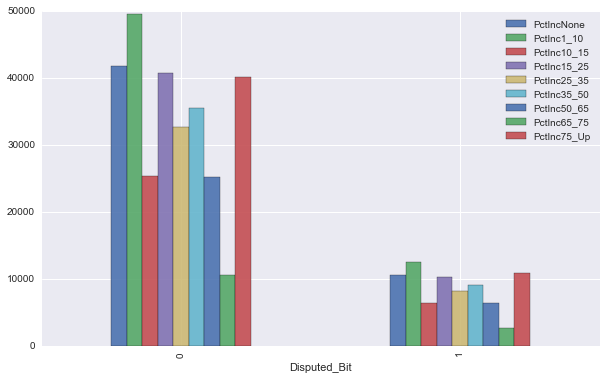

In [470]:
Voltron[['PctIncNone', 'PctInc1_10', 'PctInc10_15', 'PctInc15_25', 'PctInc25_35', 'PctInc35_50', 'PctInc50_65', 'PctInc65_75', 'PctInc75_Up', 'Disputed_Bit']].groupby('Disputed_Bit').sum().plot(kind='bar', alpha=0.9)

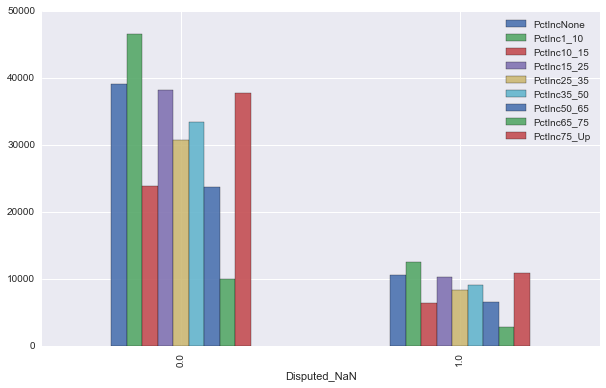

In [471]:
Voltron[['PctIncNone', 'PctInc1_10', 'PctInc10_15', 'PctInc15_25', 'PctInc25_35', 'PctInc35_50', 'PctInc50_65', 'PctInc65_75', 'PctInc75_Up', 'Disputed_NaN']].groupby('Disputed_NaN').sum().plot(kind='bar', alpha=0.9)

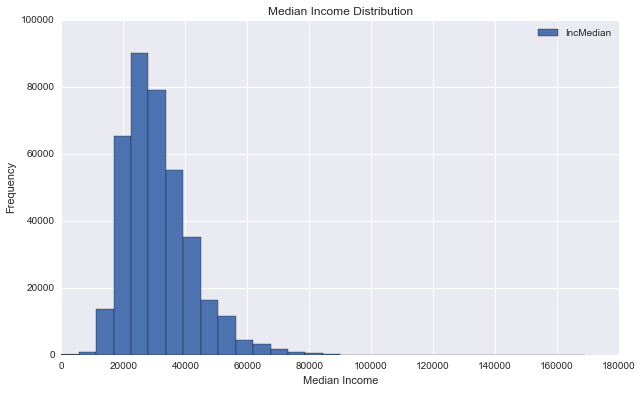

In [472]:
Voltron[['IncMedian']].plot(kind='hist', bins=30, title='Median Income Distribution')
plt.xlabel('Median Income')
plt.ylabel('Frequency')

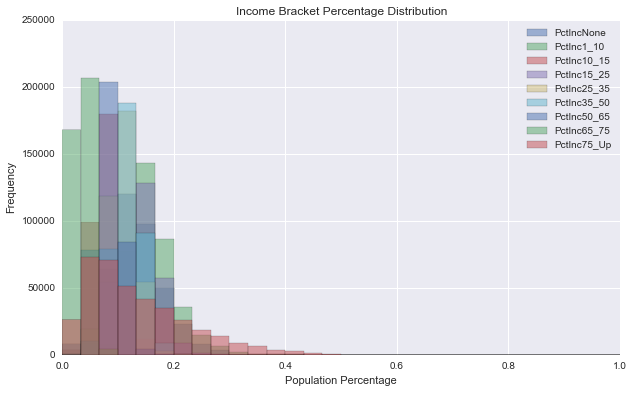

In [473]:
Voltron[['PctIncNone', 'PctInc1_10', 'PctInc10_15', 'PctInc15_25', 'PctInc25_35', 'PctInc35_50', 'PctInc50_65', 'PctInc65_75', 'PctInc75_Up']].plot(kind='hist', bins=30, title='Income Bracket Percentage Distribution', alpha=0.5)
plt.xlabel('Population Percentage')
plt.ylabel('Frequency')

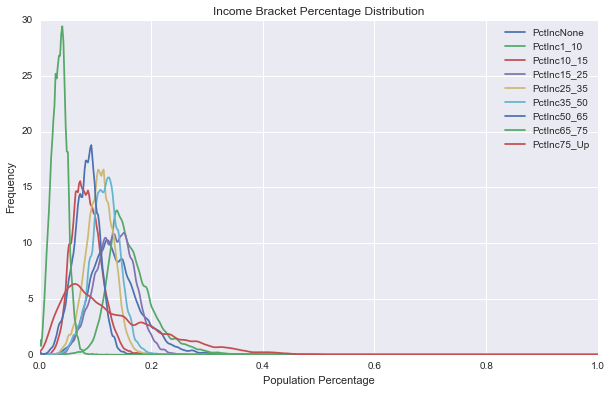

In [474]:
#This takes long to generate, but offers a better view of all the distributions
Voltron[['PctIncNone', 'PctInc1_10', 'PctInc10_15', 'PctInc15_25', 'PctInc25_35', 'PctInc35_50', 'PctInc50_65', 'PctInc65_75', 'PctInc75_Up']].plot(kind='density', title='Income Bracket Percentage Distribution', xlim=(0, 1))
plt.xlabel('Population Percentage')
plt.ylabel('Frequency')

### Historgram Analaysis
From the histogram, while frequency may seem to be an important factor, what we're actually looking for is higher frequencies of higher percentages.  In this case, it seems like the density graph is easier to read.  The generally the higher income brackets are more frequent at the high income percentages.

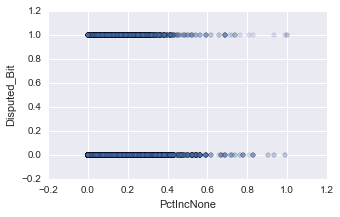

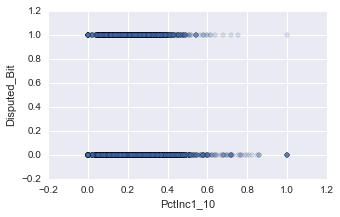

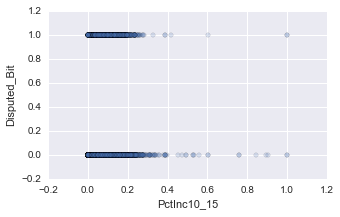

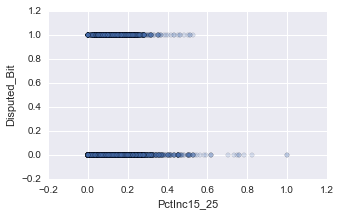

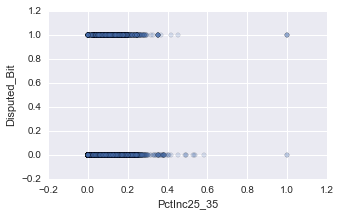

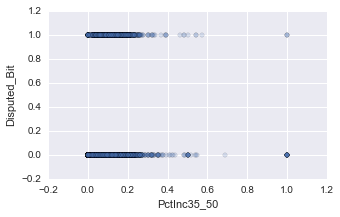

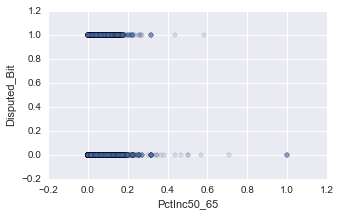

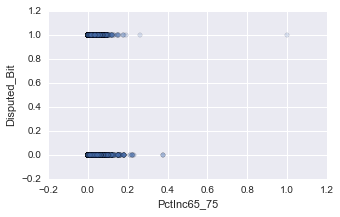

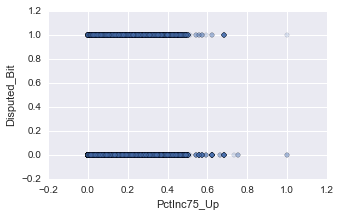

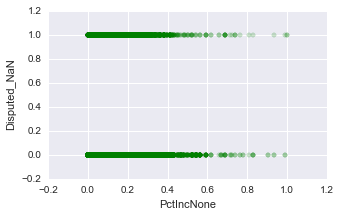

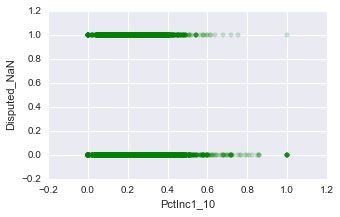

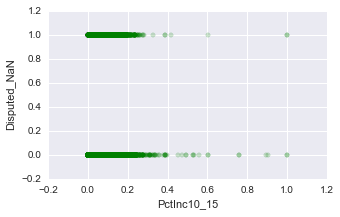

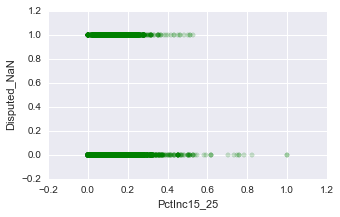

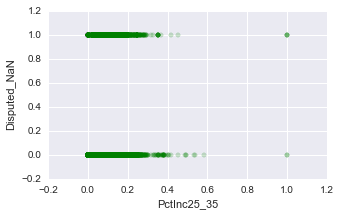

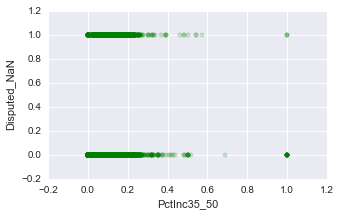

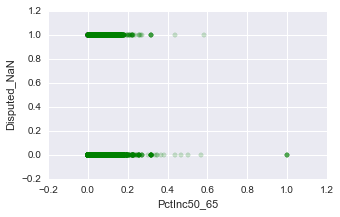

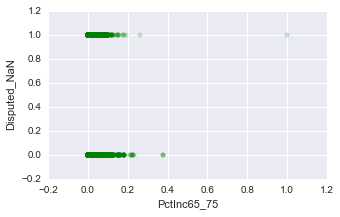

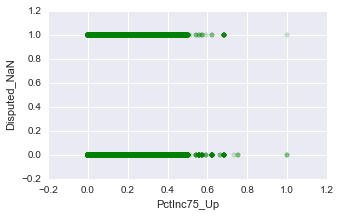

In [477]:
plt.rcParams['figure.figsize'] = (5, 3)

Voltron.plot(kind='scatter', x='PctIncNone', y='Disputed_Bit', alpha = 0.2)
Voltron.plot(kind='scatter', x='PctInc1_10', y='Disputed_Bit', alpha = 0.2)
Voltron.plot(kind='scatter', x='PctInc10_15', y='Disputed_Bit', alpha = 0.2)
Voltron.plot(kind='scatter', x='PctInc15_25', y='Disputed_Bit', alpha = 0.2)
Voltron.plot(kind='scatter', x='PctInc25_35', y='Disputed_Bit', alpha = 0.2)
Voltron.plot(kind='scatter', x='PctInc35_50', y='Disputed_Bit', alpha = 0.2)
Voltron.plot(kind='scatter', x='PctInc50_65', y='Disputed_Bit', alpha = 0.2)
Voltron.plot(kind='scatter', x='PctInc65_75', y='Disputed_Bit', alpha = 0.2)
Voltron.plot(kind='scatter', x='PctInc75_Up', y='Disputed_Bit', alpha = 0.2)

Voltron.plot(kind='scatter', x='PctIncNone', y='Disputed_NaN', color='green', alpha = 0.2)
Voltron.plot(kind='scatter', x='PctInc1_10', y='Disputed_NaN', color='green', alpha = 0.2)
Voltron.plot(kind='scatter', x='PctInc10_15', y='Disputed_NaN', color='green', alpha = 0.2)
Voltron.plot(kind='scatter', x='PctInc15_25', y='Disputed_NaN', color='green', alpha = 0.2)
Voltron.plot(kind='scatter', x='PctInc25_35', y='Disputed_NaN', color='green', alpha = 0.2)
Voltron.plot(kind='scatter', x='PctInc35_50', y='Disputed_NaN', color='green', alpha = 0.2)
Voltron.plot(kind='scatter', x='PctInc50_65', y='Disputed_NaN', color='green', alpha = 0.2)
Voltron.plot(kind='scatter', x='PctInc65_75', y='Disputed_NaN', color='green', alpha = 0.2)
Voltron.plot(kind='scatter', x='PctInc75_Up', y='Disputed_NaN', color='green', alpha = 0.2)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000144619588>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000141658438>]], dtype=object)

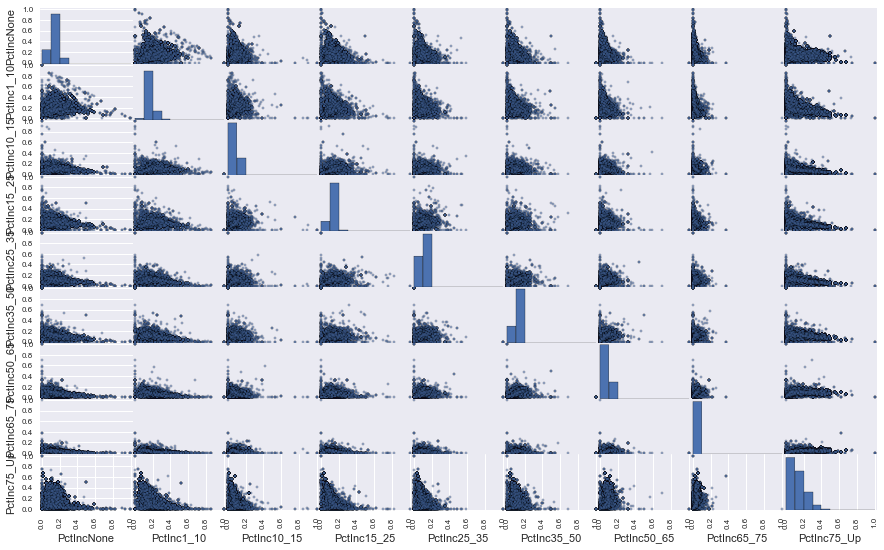

In [483]:
plt.rcParams['figure.figsize'] = (15, 9)
pd.scatter_matrix(Voltron[['PctIncNone', 'PctInc1_10', 'PctInc10_15', 'PctInc15_25', 'PctInc25_35', 'PctInc35_50', 'PctInc50_65', 'PctInc65_75', 'PctInc75_Up']])

### Scatterplot Analaysis
As to be expected, the scatterplots show an inverse relationship between the income brackets.  There is also definitely a likelihood to not dispute, but it looks like it may sway in favor of the lower income brackets.  The difference between accounting for Non-Reponse values is not visibly noticable.

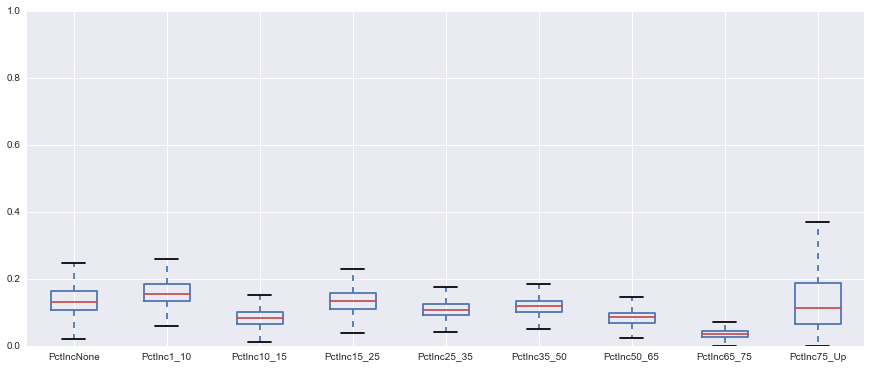

In [568]:
plt.rcParams['figure.figsize'] = (15, 6)

Voltron[['PctIncNone', 'PctInc1_10', 'PctInc10_15', 'PctInc15_25', 'PctInc25_35', 'PctInc35_50', 'PctInc50_65', 'PctInc65_75', 'PctInc75_Up']].plot(kind='box')

### Boxplot Analysis

The top income bracketseems to have the highest variances

# Linear Regression

## Using the income brackets as features

I've decided to utilize linear regression so that we can interpret the the effects of income brackets on the consumer's decisions to dispute the company's response.

In [485]:
# create X and y
feature_cols = ['PctIncNone', 'PctInc1_10', 'PctInc10_15', 'PctInc15_25', 'PctInc25_35', 'PctInc35_50', 'PctInc50_65', 'PctInc65_75', 'PctInc75_Up']
X = Voltron[feature_cols]
y = Voltron.Disputed_Bit

# import, instantiate, fit
linreg = LinearRegression()
linreg.fit(X, y)

# print the coefficients
print linreg.intercept_
print linreg.coef_

-79844029465.6
[  7.98440295e+10   7.98440295e+10   7.98440295e+10   7.98440295e+10
   7.98440295e+10   7.98440295e+10   7.98440295e+10   7.98440295e+10
   7.98440295e+10]


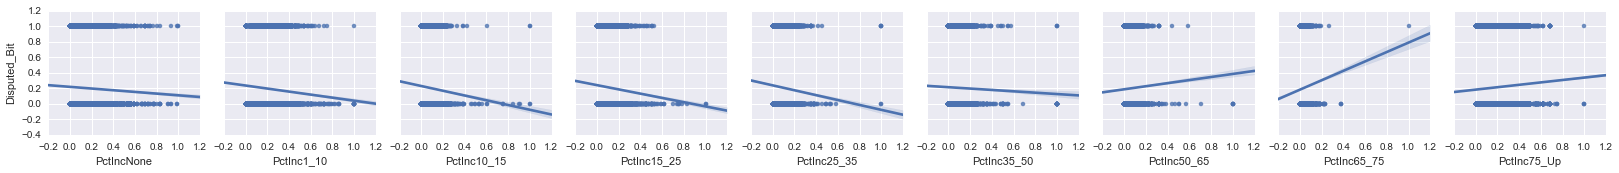

In [486]:
# multiple scatter plots with fit lines. Takes long to generate!!!
sns.pairplot(Voltron, x_vars=feature_cols, y_vars='Disputed_Bit', kind='reg')

In [497]:
# create X and y
feature_cols = ['PctIncNone', 'PctInc1_10', 'PctInc10_15', 'PctInc15_25', 'PctInc25_35', 'PctInc35_50', 'PctInc50_65', 'PctInc65_75', 'PctInc75_Up']
X = Voltron.dropna(subset = ['Disputed_NaN'])[feature_cols]
y = Voltron.dropna(subset = ['Disputed_NaN']).Disputed_NaN

# import, instantiate, fit
linreg = LinearRegression()
linreg.fit(X, y)

# print the coefficients
print linreg.intercept_
print linreg.coef_

-52623625117.7
[  5.26236251e+10   5.26236251e+10   5.26236251e+10   5.26236251e+10
   5.26236251e+10   5.26236251e+10   5.26236251e+10   5.26236251e+10
   5.26236251e+10]


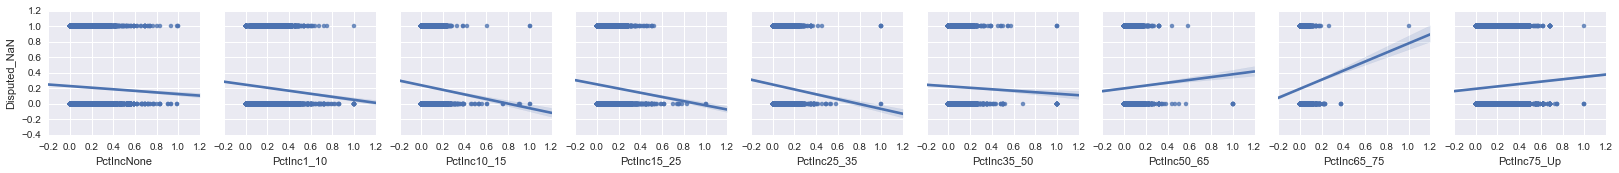

In [498]:
# multiple scatter plots with fit lines. Takes long to generate!!!
sns.pairplot(Voltron.dropna(subset = ['Disputed_NaN']), x_vars=feature_cols, y_vars='Disputed_NaN', kind='reg')

## Analysis of Linear Regression Using All Brackets
Strangely, the listed coefs don't seem to make sense when compared to the scatterplots.  While the coefs show that all their values to be the same, the plots show an increasingly positive coefficient toward higher brackets.  There is no visible difference between the two ways to treat NaN response values

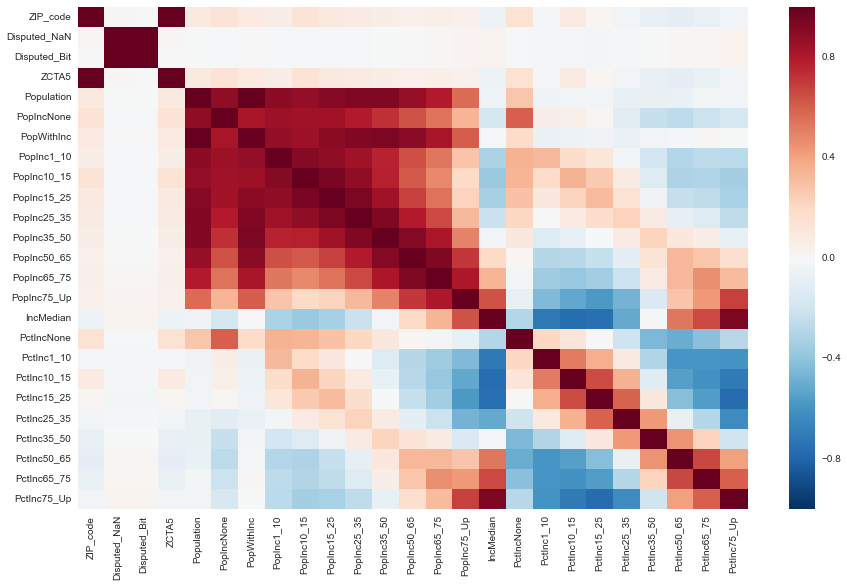

In [487]:
# heatmap
sns.heatmap(Voltron.corr())

## Trying Median Income as the feature

The heatmaps shows that much of the Income data is highly correlated with eachother with the giant red block.  Only once the data becomes transformed to control for population, then it becomes a little more ambiguous.  Strangely, the highest income bracket percentage is correlated with the median income.  Because the raw income brackets are often strongly correlated, let's try running the the model with the median income instead.

In [501]:
# create X and y
feature_cols = ['IncMedian']
X = Voltron[feature_cols]
y = Voltron.Disputed_Bit

# import, instantiate, fit
linreg = LinearRegression()
linreg.fit(X, y)

# print the coefficients
print linreg.intercept_
print linreg.coef_

0.166057850741
[  1.20547524e-06]


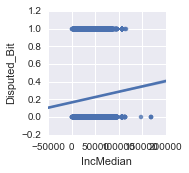

In [502]:
# Takes long to generate!!!
sns.pairplot(Voltron, x_vars=feature_cols, y_vars='Disputed_Bit', kind='reg')

In [158]:
print linreg.predict([1])
print linreg.predict([0])

[ 0.16605016]
[ 0.16604896]


## At what median income does the regression hit the 0.50 threshold?

y = mX + b

0.5 = 0.00000120547524X + 0.166057850741

X = (0.5 - 0.166057850741)/0.00000120547524

In [504]:
threshold = (0.5 - 0.166057850741)/0.00000120547524
print threshold

linreg.predict([277021.159936])

277021.159936


array([ 0.5])

## Analysis of Median Income

While a median income needed to hit the threshold is pretty ridiculous, it gives a lot more interpretability than the coefficients using all the income brackets.  At the same time, it seems to bolster that you're more likely to dispute a claim response if you're wealthier.

## Conduct a Train-Test-Split to test feature combinations

*I chose 36 as my random state value because I like the number, no other real reason.*

In [523]:
#create the function to make it easier to run multiple test
def train_test_rmse(feature_cols):
    X = Voltron[feature_cols]
    y = Voltron.Disputed_Bit
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=36)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [521]:
#All Features
print train_test_rmse(['PctIncNone', 'PctInc1_10', 'PctInc10_15', 'PctInc15_25', 'PctInc25_35', 'PctInc35_50', 'PctInc50_65', 'PctInc65_75', 'PctInc75_Up'])

189173439941.0
[ -1.89173440e+11  -1.89173440e+11  -1.89173440e+11  -1.89173440e+11
  -1.89173440e+11  -1.89173440e+11  -1.89173440e+11  -1.89173440e+11
  -1.89173440e+11]
0.402509531674


In [510]:
#Single Features
print train_test_rmse(['IncMedian'])
print train_test_rmse(['PctIncNone'])
print train_test_rmse(['PctInc1_10'])
print train_test_rmse(['PctInc10_15'])
print train_test_rmse(['PctInc15_25'])
print train_test_rmse(['PctInc25_35'])
print train_test_rmse(['PctInc35_50'])
print train_test_rmse(['PctInc50_65'])
print train_test_rmse(['PctInc65_75'])
print train_test_rmse(['PctInc75_Up'])

0.402540545544
0.402757355442
0.402658819809
0.402701137752
0.402676150148
0.402721135214
0.402814371297
0.402759345805
0.402704390149
0.402517846265


In [517]:
#Random Testing Block
print train_test_rmse(['PctInc1_10', 'PctInc10_15', 'PctInc15_25', 'PctInc25_35', 'PctInc75_Up'])

0.402507844079


In [525]:
# create X and y
feature_cols = ['PctInc1_10', 'PctInc10_15', 'PctInc15_25', 'PctInc25_35', 'PctInc75_Up']
X = Voltron[feature_cols]
y = Voltron.Disputed_Bit

# import, instantiate, fit
linreg = LinearRegression()
linreg.fit(X, y)

# print the coefficients
print linreg.intercept_
print linreg.coef_

0.159955330742
[-0.01720969  0.13902703  0.03406348  0.03759188  0.19613942]


In [518]:
# Compare with NULL
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=36)
y_null = np.zeros_like(y_test, dtype=float)
y_null.fill(y_test.mean())

print 'RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_null))

RMSE: 0.402806493821


## Loss Function Analysis


After some trial and error, it seems that the one with 5 features gives a lower error than the model with all features.  Almost all of the models do marginally better than the NULL model.

Given that this is a classification problem, I would probably say that the models are equal to the NULL as they would both predict 'NO' for every record, but for different reasons.  The NULL model would simply choose 'NO' the majority, while the linear regression would choose 'NO' because it never hits above 0.50.

# Logistic Regression

In [539]:
# fit a logistic regression model and store the class predictions

logreg = LogisticRegression()
feature_cols = ['PctIncNone', 'PctInc1_10', 'PctInc10_15', 'PctInc15_25', 'PctInc25_35', 'PctInc35_50', 'PctInc50_65', 'PctInc65_75', 'PctInc75_Up']
X = Voltron[feature_cols]
y = Voltron.Disputed_Bit
logreg.fit(X, y)
Voltron['PredictedDispute'] = logreg.predict(X)
Voltron['PredictedDispute_prob'] = logreg.predict_proba(X)[:, 1]
print logreg.intercept_ 
zip(feature_cols, logreg.coef_[0])

[-1.20647419]


[('PctIncNone', -0.46814585217491361),
 ('PctInc1_10', -0.52477694285144516),
 ('PctInc10_15', 0.44302885078174803),
 ('PctInc15_25', -0.24201961468996208),
 ('PctInc25_35', -0.2993667941864564),
 ('PctInc35_50', -0.11660199272497943),
 ('PctInc50_65', -0.82007400236128747),
 ('PctInc65_75', 0.079310301582651357),
 ('PctInc75_Up', 0.74217185965149846)]

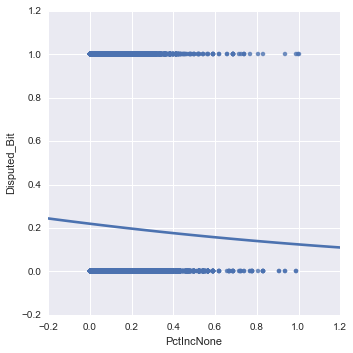

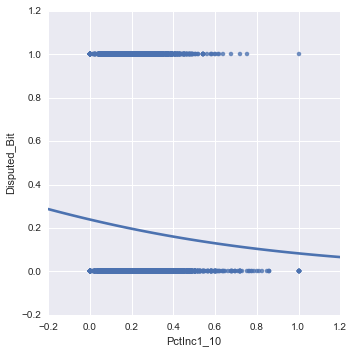

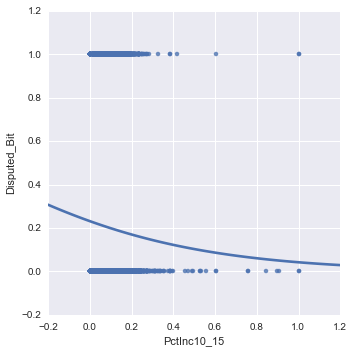

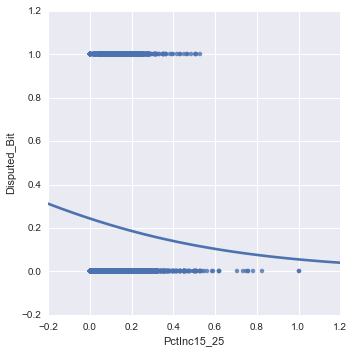

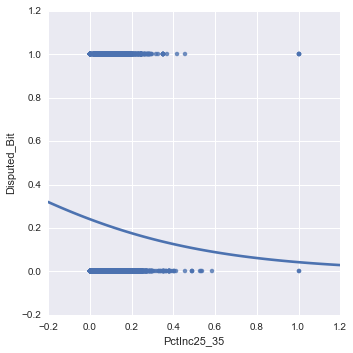

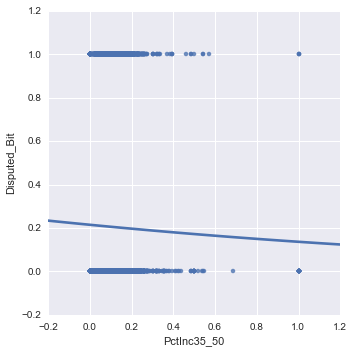

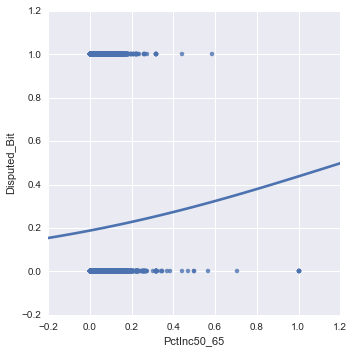

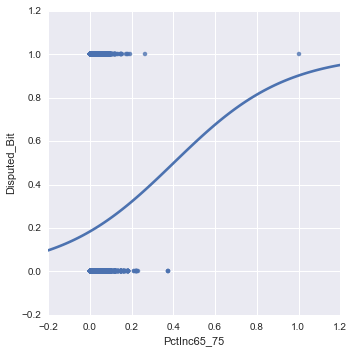

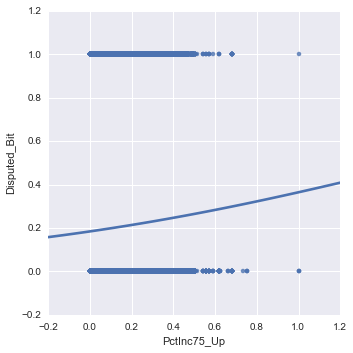

In [544]:
sns.lmplot(x='PctIncNone', y='Disputed_Bit', data=Voltron, ci=None, logistic=True)
sns.lmplot(x='PctInc1_10', y='Disputed_Bit', data=Voltron, ci=None, logistic=True)
sns.lmplot(x='PctInc10_15', y='Disputed_Bit', data=Voltron, ci=None, logistic=True)
sns.lmplot(x='PctInc15_25', y='Disputed_Bit', data=Voltron, ci=None, logistic=True)
sns.lmplot(x='PctInc25_35', y='Disputed_Bit', data=Voltron, ci=None, logistic=True)
sns.lmplot(x='PctInc35_50', y='Disputed_Bit', data=Voltron, ci=None, logistic=True)
sns.lmplot(x='PctInc50_65', y='Disputed_Bit', data=Voltron, ci=None, logistic=True)
sns.lmplot(x='PctInc65_75', y='Disputed_Bit', data=Voltron, ci=None, logistic=True)
sns.lmplot(x='PctInc75_Up', y='Disputed_Bit', data=Voltron, ci=None, logistic=True)

## Analysis
When creating a model using all of the features, the highest income bracket has the greatest impact and is the only coefficient that can hit above 0.5.  However, when looking at the logistic regression lines, they naturally mirror that of the linear regression lines, but with the smoother curves.  The 65-75 Bracket seems to have the most traditional looking S-curve.

## Conduct another Train-Test-Split for Logistic Regression

### Testing with all features

In [575]:
feature_cols = ['PctIncNone', 'PctInc1_10', 'PctInc10_15', 'PctInc15_25', 'PctInc25_35', 'PctInc35_50', 'PctInc50_65', 'PctInc65_75', 'PctInc75_Up']
X = Voltron[feature_cols]
y = Voltron.Disputed_Bit
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=36)
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train, y_train)
y_pred_class = logreg.predict(X_test)
#Model Accuracy
print metrics.accuracy_score(y_test, y_pred_class)
#Null Accuracy Comparison
print max(y_test.mean(), 1 - y_test.mean())
#Confusion Matrix
print metrics.confusion_matrix(y_test, y_pred_class)

0.796221080505
0.796221080505
[[75473     0]
 [19316     0]]


In [592]:
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1][1]
TN = confusion[0][0]
FP = confusion[0][1]
FN = confusion[1][0]

print 'True Positives:', TP
print 'True Negatives:', TN
print 'False Positives:', FP
print 'False Negatives:', FN

# Sensitivity
print TP / float(TP + FN)

# Specificity
print TN / float(TN + FP)

True Positives: 0
True Negatives: 75473
False Positives: 0
False Negatives: 19316
0.0
1.0


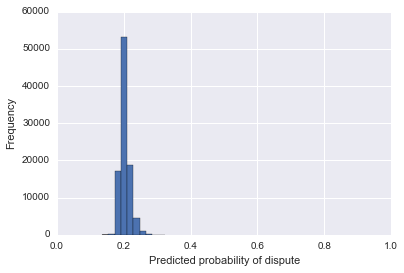

In [578]:
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(y_pred_prob)
plt.xlim(0, 1)
plt.xlabel('Predicted probability of dispute')
plt.ylabel('Frequency')

In [600]:
print max(y_pred_prob)

0.323458216517


## Confusion Matrix Analysis
Given that the confusion matrix resulted in everything predicted as 'No', I believe this puts the nail in the coffin that the features are not strongly predictive of the response in the way the problem is currently constructed.  However, we can see that there is roughly a predicted probability of 20% to dispute.  The threshold must at least be 32% for any shift in the matrix to occur.

# Classification Tree
To create a model with greater interpretability, as well as to perhaps force rules to give scenarios of a dispute, a classification tree seems to make sense.

In [605]:

feature_cols = ['PctIncNone', 'PctInc1_10', 'PctInc10_15', 'PctInc15_25', 'PctInc25_35', 'PctInc35_50', 'PctInc50_65', 'PctInc65_75', 'PctInc75_Up']
X = Voltron[feature_cols]
y = Voltron.Disputed_Bit
from sklearn.tree import DecisionTreeClassifier
treeclf = DecisionTreeClassifier(random_state=1 , max_depth=3)
treeclf.fit(X, y)

export_graphviz(treeclf, out_file='tree_Voltron3.dot', feature_names=feature_cols)

<img src="tree_Voltron3.png">
*dot -Tpng tree_Voltron3.dot -o tree_Voltron3.png*

In [607]:
pd.DataFrame({'feature':feature_cols, 'importance':treeclf.feature_importances_})

,feature,importance
0,PctIncNone,0.078053
1,PctInc1_10,0.000000
2,PctInc10_15,0.065551
3,PctInc15_25,0.000000
4,PctInc25_35,0.034833
5,PctInc35_50,0.000000
6,PctInc50_65,0.000000
7,PctInc65_75,0.000000
8,PctInc75_Up,0.821563


## Classification Tree Analysis

Based on the importance, the top income bracket seems to be by far the greatest feature.

Further work may involve optimization for the chosen depth.

# Challenges and Successes

The biggest challenge that I faced was figuring out a question that was meaningful that would be solvable using one of the modeling techniques shown in class.  While I understand that not all questions can be answered, or that the available data may not be appropriate to answer the question; developing a question based on given data is another story.  Given that the biggest hurdle I faces was that I lack the Subject Matter Expertise, it was difficult to get a good question simply at a glance of the data.

As for successes.  This project has encouraged me to really dig through the datasaet and find out what each field really means.  Perhaps using the income brackets weren't the best features to use, but I really wanted to incorporate the income side of the data while controlling for variations in zipcode population.  The Median field seems to be a lot more reasonable, and I'm sure many other demographic measurements could be far greater determinants of a consumer disputing.

# Possible extensions or business applications of your project

Given that this was originally a Skills Assessment test, I don't think there are any direct business applications.  However, there are many different types of data that are available in the ACS and income may not be the most interesting choice.  Furthermore, I think simply choosing fields within the Complaints data as features would have netted a better result, but part of the exercise was to be able to join the datasets and clean them.

# Conclusions and key learnings

For the most part, people generally don't dispute company responses to consumer complaints.  The motivation for them disputing hinges on far too many factors to simply assume that income bracket distribution of their zipcode would be a good indicator.  However, what I did find interesting were the overall distibutions of those brackets within the complaints.  Perhaps limiting the scope of the project to only a single state or region would probably have made the findings more applicable.